# Libraries and Data

In [1]:
# # Mount Drive to access files
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# # Path to the folder
# %cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [2]:
# Loading the Data of weekly customer complaints
# and set the date as the index
df = pd.read_csv("Amazon.csv", index_col = "Date", parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [3]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5842 entries, 1997-05-15 to 2020-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5842 non-null   float64
 1   High       5842 non-null   float64
 2   Low        5842 non-null   float64
 3   Close      5842 non-null   float64
 4   Adj Close  5842 non-null   float64
 5   Volume     5842 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 319.5 KB


# Data Pre-processing

In [53]:
# Remove comma from column 'complaints' and transform the values into float
df['complaints'] = df['complaints'].str.replace(',', '').astype(float)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750.0,37.26%,1,0,0
2018-01-08,1701.0,35.38%,0,0,0
2018-01-15,1711.0,36.22%,1,0,0
2018-01-22,1443.0,38.33%,1,0,0
2018-01-29,1397.0,36.34%,0,0,0


There is no preprocessing in the data to do

In [4]:
# df.asfreq("W-Mon") - convert the time series data to a specified frequency, in this case, weekly data with Monday as the anchor day.
# Setting freq to W implies that the week starts on a Sunday
df_w_Mon = df.asfreq("W-Mon")
df_w_Mon.index

DatetimeIndex(['1997-05-19', '1997-05-26', '1997-06-02', '1997-06-09',
               '1997-06-16', '1997-06-23', '1997-06-30', '1997-07-07',
               '1997-07-14', '1997-07-21',
               ...
               '2020-05-25', '2020-06-01', '2020-06-08', '2020-06-15',
               '2020-06-22', '2020-06-29', '2020-07-06', '2020-07-13',
               '2020-07-20', '2020-07-27'],
              dtype='datetime64[ns]', name='Date', length=1211, freq='W-MON')

A list of commonly used frequency aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

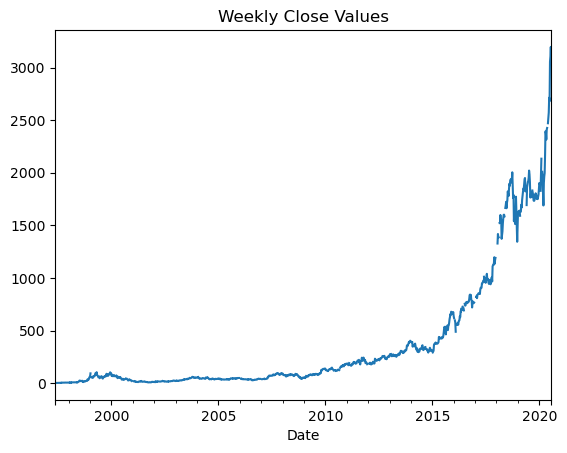

In [5]:
# Plot the weekly close values
df_w_Mon['Close'].plot(title = 'Weekly Close Values')
plt.show()

We can see that some values Do not exist, and it can be due to holidays and so on

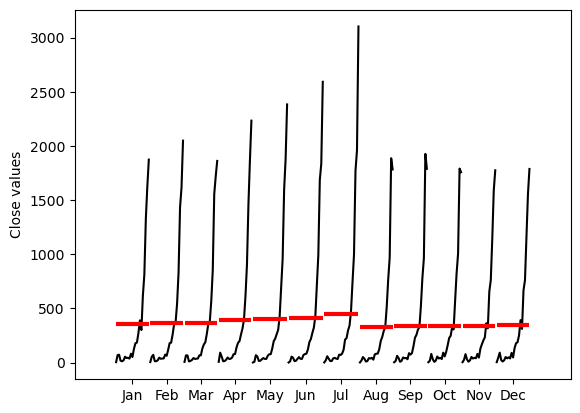

In [6]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of the cloe values
month_plot(df_w_Mon['Close'].resample('M').mean(),
           ylabel = 'Close values')
plt.show()

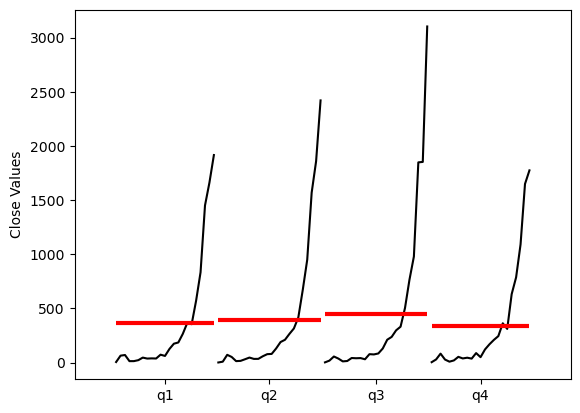

In [7]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of the close values
quarter_plot(df_w_Mon['Close'].resample('Q').mean(),
           ylabel = 'Close Values')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

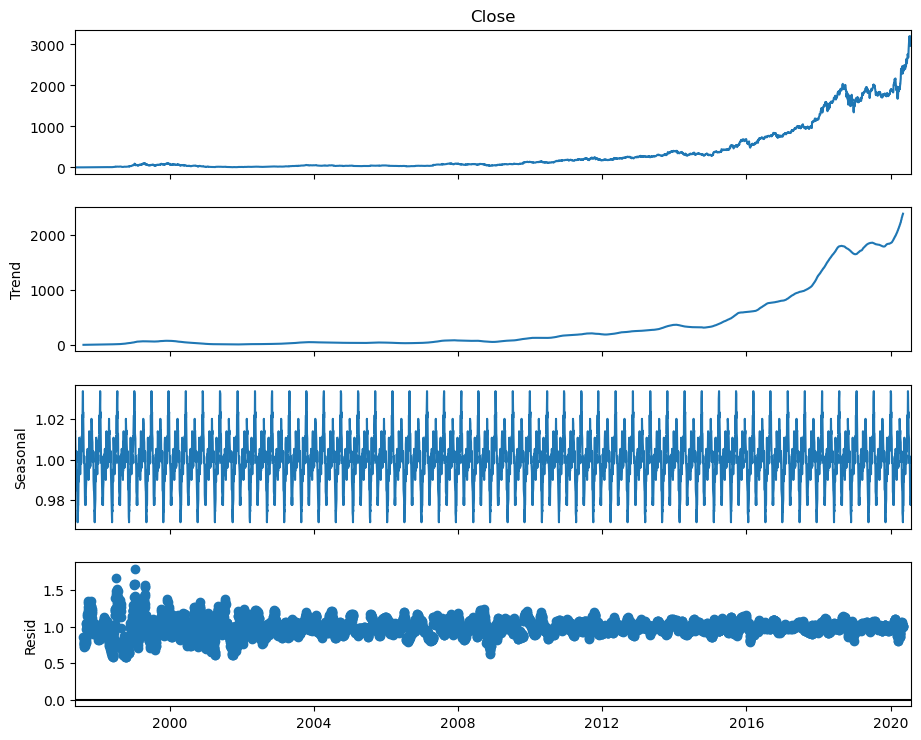

In [8]:
# Seasonal Decomposition Plots for close values
# Multiplicative model type, with yearly seasonality (52 weeks)
decomposition = seasonal_decompose(df['Close'],
                                   model = 'mul',
                                   period = 120)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


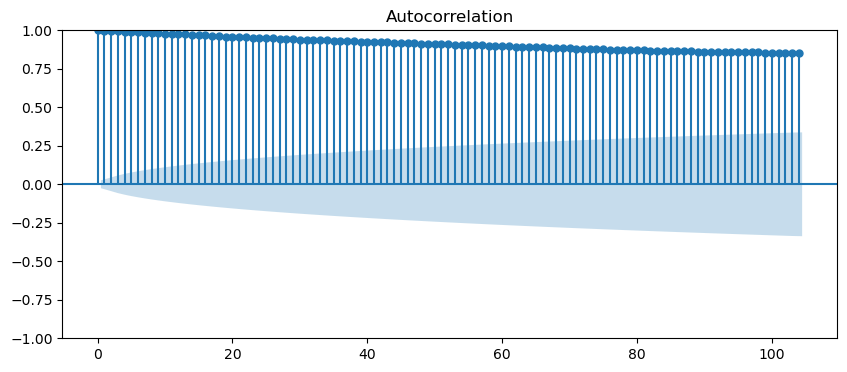

In [9]:
# Plot the autocorrelation (ACF) of close values
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(df['Close'], lags = 104, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

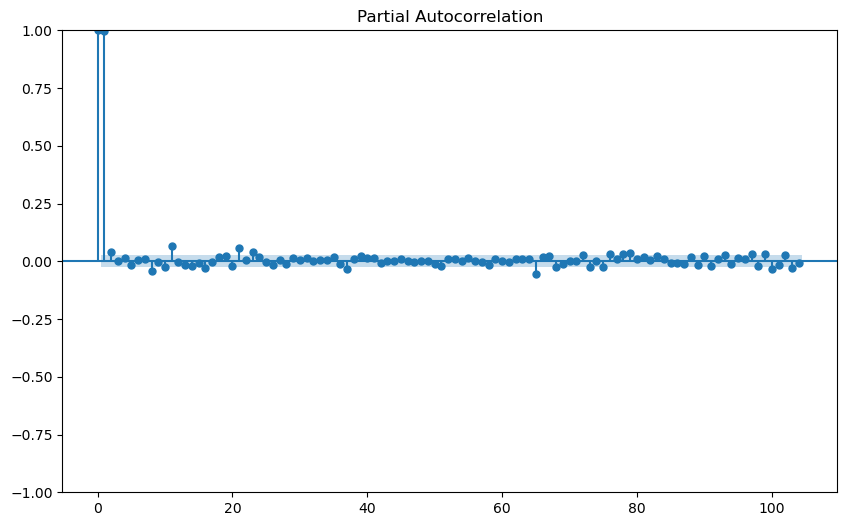

In [10]:
# Plot the partial autocorrelation (PACF) of close values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['Close'], lags = 104, ax = ax)
plt.show()

# Training and test

# Goal : to predict the next quarter (13 weeks)

In [11]:
# Training and Test Split
# Train: all data except last n periods of the column 'Close'
# Test: last n periods of the column 'complaints'

periods = 600
train, test = df.iloc[:-periods,3], df.iloc[-periods:, 3 ]
test.head()

Date
2018-03-15    1582.319946
2018-03-16    1571.680054
2018-03-19    1544.930054
2018-03-20    1586.510010
2018-03-21    1581.859985
Name: Close, dtype: float64

# Simple Exponential Smoothing

Simple Exponential Smoothing assigns exponentially decreasing weights to past observations, giving more influence to recent data.

It is especially useful when there is no clear trend or seasonal pattern.

In [12]:
# Create a Simple Exponential Smoothing model using the training data.
model_simple = SimpleExpSmoothing(train).fit()

# Use the fitted model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_simple = model_simple.forecast(len(test))
predictions_simple.index = test.index
predictions_simple

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2018-03-15    1591.0
2018-03-16    1591.0
2018-03-19    1591.0
2018-03-20    1591.0
2018-03-21    1591.0
               ...  
2020-07-27    1591.0
2020-07-28    1591.0
2020-07-29    1591.0
2020-07-30    1591.0
2020-07-31    1591.0
Length: 600, dtype: float64

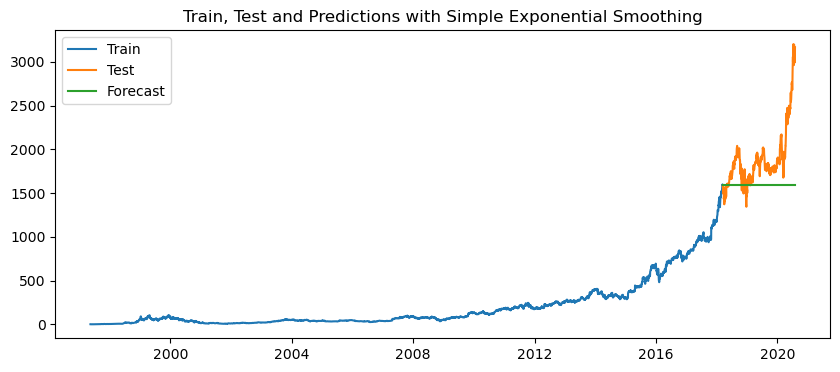

In [13]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_simple, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

# Double Exponential Smoothing

Double Exponential Smoothing (DES), also known as Holt’s Linear Trend Model, is used when the time series data exhibits a trend.

Unlike Simple Exponential Smoothing, which is suitable for data without trends or seasonality, DES can account for both the level and the trend in the data

Key Features:
- Trend Handling -  making it suitable for time series data that show a consistent upward or downward trend over time.
- Components - DES involves two components: the level (smoothed value) and the trend.

In [14]:
# Double Exponential Smoothing Model
# Initialize and fit an Exponential Smoothing model to the training data
# Use a multiplicative trend component ('mul') and no seasonal component (seasonal=None)

#El model el mafroud yb2a esmo Holt Winters bas el library msamyaah exponential smoothing

model_double = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = None).fit()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Use the fitted Double Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_double = model_double.forecast(len(test))
predictions_double.index = test.index
predictions_double

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2018-03-15     1598.340214
2018-03-16     1605.690652
2018-03-19     1613.074893
2018-03-20     1620.493093
2018-03-21     1627.945407
                  ...     
2020-07-27    24507.417698
2020-07-28    24620.122274
2020-07-29    24733.345155
2020-07-30    24847.088725
2020-07-31    24961.355378
Length: 600, dtype: float64

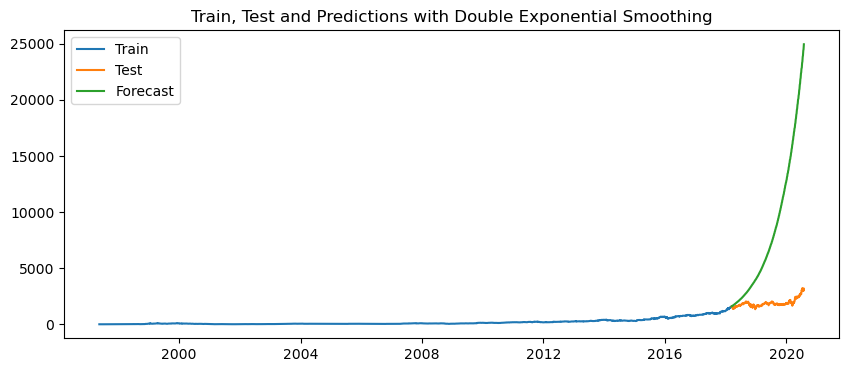

In [16]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train, test, and forecasts values
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_double, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Double Exponential Smoothing")
plt.legend()
plt.show()

# Triple Exponential Smoothing (Holt-Winters method)

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, extends Double Exponential Smoothing by adding a seasonal component to handle data with seasonal patterns in addition to trends.

Key Features:
- Seasonality Handling - Triple Exponential Smoothing accommodates time series data with seasonal patterns, which can be daily, weekly, monthly, quarterly, or annual.
- Components - It involves three components: level (smoothed value), trend, and seasonal.

In [17]:
# Triple Exponential Smoothing Model
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "mul",
                                    seasonal_periods = 52).fit()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [18]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_triple = model_triple.forecast(len(test))
predictions_triple.index = test.index
predictions_triple

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2018-03-15     1612.575499
2018-03-16     1639.976060
2018-03-19     1678.594944
2018-03-20     1711.583156
2018-03-21     1737.579675
                  ...     
2020-07-27    42980.063918
2020-07-28    43403.708465
2020-07-29    43265.669641
2020-07-30    43675.571675
2020-07-31    43410.377218
Length: 600, dtype: float64

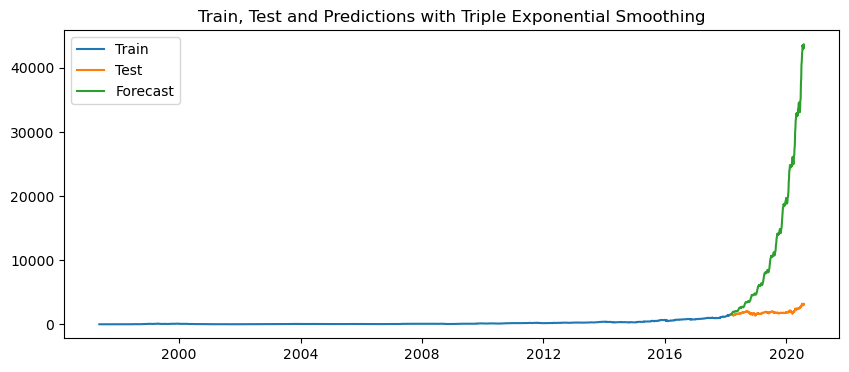

In [19]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train, test, and forecasts values
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_triple, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Triple Exponential Smoothing")
plt.legend()
plt.show()

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

In [20]:
from math import sqrt


# Calculating the MAE, RMSE, and MAPE
# between the test values and our prediction values
mae = mean_absolute_error(test, predictions_triple)
rmse = sqrt(mean_squared_error(test, predictions_triple))
mape = mean_absolute_percentage_error(test, predictions_triple)

print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

The MAE is 11024.85
The RMSE is 15573.81
The MAPE is 528.96 %


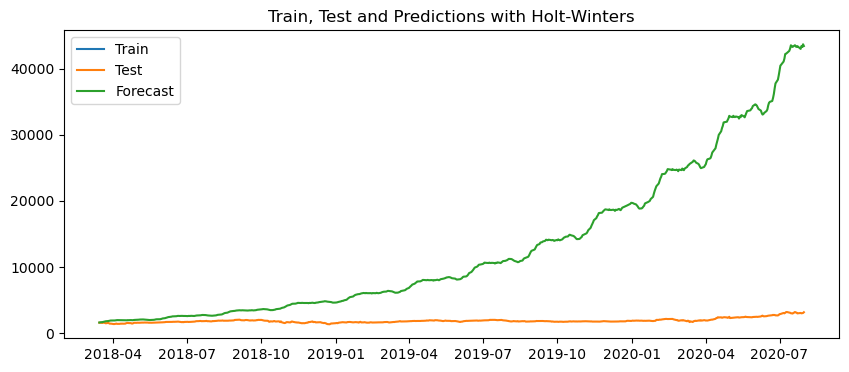

The MAE is 11024.85
The RMSE is 15573.81
The MAPE is 528.96 %


In [21]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = sqrt(mean_squared_error(test, predictions))
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Call the model_assessment function with the specified arguments
model_assessment(train['2022-06':], test, predictions_triple, "Holt-Winters")

# Predicting the future

In [22]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the whole data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)
model = ExponentialSmoothing(df.Close,
                             trend = 'add',
                             seasonal = "mul",
                             seasonal_periods = 52).fit()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
 # Predict the values for the next 10 Days
forecast_steps = 50
forecast = model.forecast(forecast_steps)
last_date = df.index[-1]
future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps)
forecast.index = future_index
forecast

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2020-08-03    3123.349153
2020-08-04    3118.621371
2020-08-05    3099.697905
2020-08-06    3127.111944
2020-08-07    3107.906965
2020-08-10    3101.431325
2020-08-11    3113.038317
2020-08-12    3073.142473
2020-08-13    3101.663017
2020-08-14    3082.339092
2020-08-17    3077.159702
2020-08-18    3066.948298
2020-08-19    3074.570333
2020-08-20    3080.047204
2020-08-21    3059.500859
2020-08-24    3071.380056
2020-08-25    3037.010067
2020-08-26    3057.163399
2020-08-27    3071.398261
2020-08-28    3080.775463
2020-08-31    3093.367511
2020-09-01    3121.077030
2020-09-02    3135.286576
2020-09-03    3100.673953
2020-09-04    3107.838164
2020-09-07    3087.698049
2020-09-08    3118.316826
2020-09-09    3133.963436
2020-09-10    3142.581252
2020-09-11    3187.070132
2020-09-14    3164.889145
2020-09-15    3180.186146
2020-09-16    3194.126278
2020-09-17    3199.611208
2020-09-18    3229.110104
2020-09-21    3232.302330
2020-09-22    3221.408467
2020-09-23    3208.244926
2020-09-24  

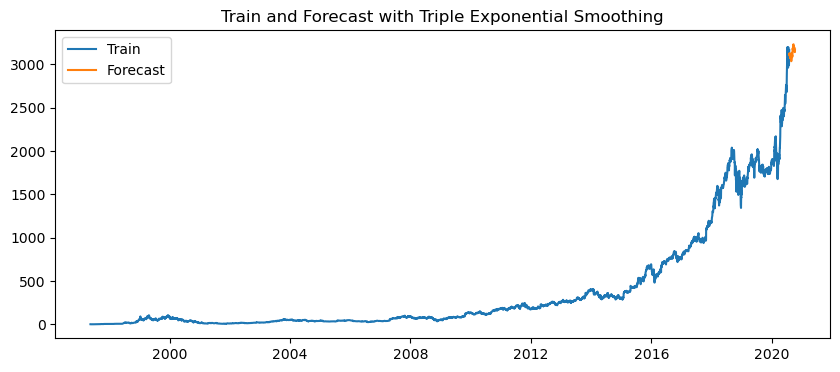

In [24]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train and forecast values
plt.plot(df.Close, label = 'Train')
plt.plot(forecast, label = "Forecast")

# Add title and legend to the plot
plt.title("Train and Forecast with Triple Exponential Smoothing")
plt.legend()
plt.show()

In [25]:
# Function to plot the train and forecast values
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot train and forecast values
  plt.plot(df.complaints, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # Add title and legend to the plot
  plt.title("Train and Forecast with Triple Exponential Smoothing")
  plt.legend()
  plt.show()

# Daily Data


In [26]:
# Loading the bitcoin data and Setting the Index
df_daily = pd.read_csv("Amazon.csv", index_col = "Date", parse_dates = True)
df_daily.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1997-05-15,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1997-05-16,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
1997-05-19,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
1997-05-20,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
1997-05-21,1.635417,1.645833,1.375000,1.427083,1.427083,18853200


In [27]:
# Display information about the DataFrame, including data types and non-null counts
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5842 entries, 1997-05-15 to 2020-07-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5842 non-null   float64
 1   High       5842 non-null   float64
 2   Low        5842 non-null   float64
 3   Close      5842 non-null   float64
 4   Adj Close  5842 non-null   float64
 5   Volume     5842 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 319.5 KB


In [77]:
# Convert the DataFrame to have a daily frequency.
# This ensures that the time series is indexed by every calendar day.
df_daily = df_daily.asfreq("B")
df_daily.index

DatetimeIndex(['1997-05-15', '1997-05-16', '1997-05-19', '1997-05-20',
               '1997-05-21', '1997-05-22', '1997-05-23', '1997-05-26',
               '1997-05-27', '1997-05-28',
               ...
               '2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31'],
              dtype='datetime64[ns]', name='Date', length=6057, freq='B')

In [28]:
# Define the number of days to be used for the test set
periods = 30
# Split the data into training and test sets, taking the 4th column ('Close')
train, test = df_daily.iloc[:-periods,3], df_daily.iloc[-periods:, 3 ]
test.head(10)

Date
2020-06-19    2675.010010
2020-06-22    2713.820068
2020-06-23    2764.409912
2020-06-24    2734.399902
2020-06-25    2754.580078
2020-06-26    2692.870117
2020-06-29    2680.379883
2020-06-30    2758.820068
2020-07-01    2878.699951
2020-07-02    2890.300049
Name: Close, dtype: float64

In [29]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 7 (daily data with weekly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "mul",
                                    seasonal_periods = 30).fit()

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [30]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set. (30 days)
predictions_triple = model_triple.forecast(len(test))
last_date = df.index[-len(test)]
future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=len(test))
predictions_triple.index = future_index
predictions_triple

C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\marha\anaconda3\envs\tf_gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


2020-06-22    2658.410190
2020-06-23    2680.057319
2020-06-24    2680.163974
2020-06-25    2687.759960
2020-06-26    2688.451331
2020-06-29    2682.078956
2020-06-30    2697.890944
2020-07-01    2705.430480
2020-07-02    2710.393213
2020-07-03    2721.250504
2020-07-06    2741.858050
2020-07-07    2744.465689
2020-07-08    2754.664670
2020-07-09    2778.374784
2020-07-10    2783.597332
2020-07-13    2821.625917
2020-07-14    2809.542722
2020-07-15    2817.925188
2020-07-16    2802.974936
2020-07-17    2825.351284
2020-07-20    2836.544775
2020-07-21    2829.899518
2020-07-22    2863.466279
2020-07-23    2872.930396
2020-07-24    2893.678639
2020-07-27    2915.002079
2020-07-28    2908.790344
2020-07-29    2939.515116
2020-07-30    2957.853018
2020-07-31    2993.774157
Freq: B, dtype: float64

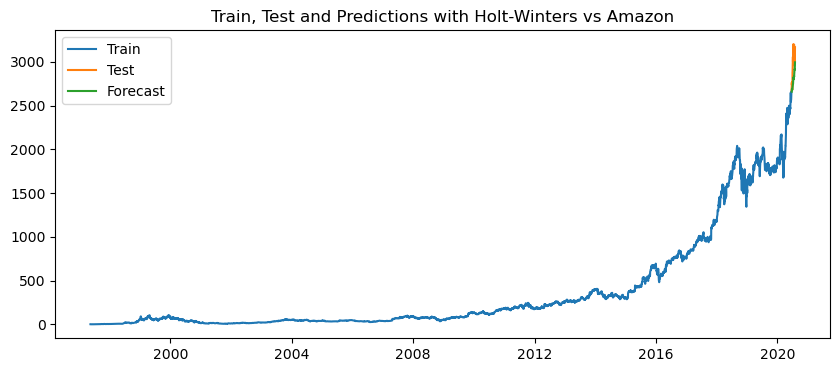

The MAE is 173.01
The RMSE is 209.30
The MAPE is 5.66 %


In [31]:
# Model Assessment
# Assess the performance of the model
# using test data starting from November 2023, comparing its predictions to the actual values of Bitcoin prices.
model_assessment(train['1990':], test, predictions_triple, "Holt-Winters vs Amazon")